In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
df= pd.read_csv("Track Acceleration Data.csv")           # columns: time, ax, ay, az, angle?, tipping_flag?

#print(df.head())
df = df.dropna()
print(df.shape)
df.head()
df.columns.tolist

t = df['Time (sec)'].values
a = df['Acceleration5 (mm/sec**2)'].values

#print(t)
#print(a)

(90, 2)


In [51]:
df = pd.read_csv("Track Acceleration Data.csv")            # columns: time, ax, ay, az, angle?, tipping_flag?

#print(df.head())
df = df.dropna()
print(df.size)


a_s = pd.Series(a).rolling(21, center=True, min_periods=1).mean().values
jerk = np.gradient(a_s, t)

# Example thresholds: tune to your file
jmax = np.percentile(np.abs(jerk), 95)  # near-top jerk that didn’t tip in the data
amax = np.percentile(np.abs(a_s), 95)     # near-top accel that didn’t tip

print("Candidate accel limit:", amax)
print("Candidate jerk limit:", jmax)

# Optional: mark “unsafe” windows from a tipping_flag or angle threshold
if 'tipping_flag' in df.columns:
    unsafe = df['tipping_flag'].astype(bool)
    print("Unsafe fraction:", unsafe.mean())

180
Candidate accel limit: 755.5472440226179
Candidate jerk limit: 231.63422382100816


triangular_profile=False, ap=2.5000 m/s^2, tj=0.2500 s, ta=2.4340 s, T=5.8681 s, D_end=19.6875 m


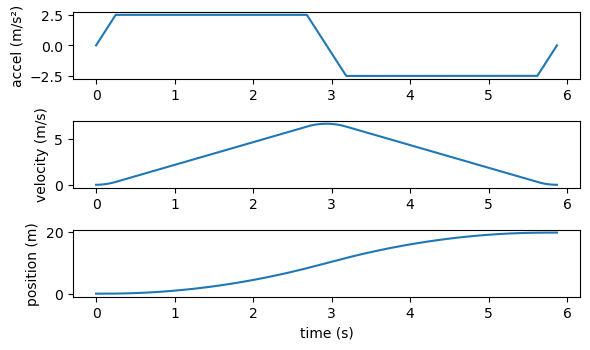

In [57]:
# ---- inputs ----
amax = 2.5     # m/s^2  (your CSV-derived limit)
jmax = 10.0    # m/s^3  (your CSV-derived limit)
D    = 10.0    # meters (target distance)

# ---- solve duration pieces ----
tj = amax / jmax  # jerk ramp time (up or down)

# distance of a HALF move when we DO reach amax and hold accel for ta:
# x_half = amax**3/jmax**2 + 1.5*amax**2/jmax*ta + 0.5*amax*ta**2
# total D = 2*x_half
A = 0.5*amax
B = 1.5*amax**2/jmax
C = 2*amax**3/jmax**2 - D

disc = B*B - 4*A*C
triangular = disc < 0  # too short to have a flat-accel segment

if triangular:
    # No constant-accel plateau. Solve for peak accel a_p < amax.
    # For triangular (jerk up, jerk down only), total distance:
    # D = 2 * ( (1/3) * a_p**3 / jmax**2 )
    ap = (1.5 * D * jmax**2) ** (1/3)
    ap = min(ap, amax)   # safety clamp
    tj = ap / jmax
    ta = 0.0
else:
    ta = (-B + np.sqrt(disc)) / (2*A)  # nonnegative root
    ap = amax

# total time: two halves, each = (jerk up tj) + (const accel ta) + (jerk down tj)
T_half = 2*tj + ta
T = 2*T_half

# ---- synthesize profiles ----
t = np.linspace(0, T, 2000)
a = np.zeros_like(t)
v = np.zeros_like(t)
x = np.zeros_like(t)

for i in range(1, len(t)):
    dt = t[i] - t[i-1]
    ti = t[i]
    th = T_half

    # Map full profile to one half (0..T_half), then mirror
    ti_half = ti if ti <= th else (T - ti)

    # piecewise accel for half profile
    if ti_half < tj:                      # jerk up: 0 -> ap
        a_i = jmax * ti_half
    elif ti_half < tj + ta:               # hold accel = ap
        a_i = ap
    elif ti_half < 2*tj + ta:             # jerk down: ap -> 0
        a_i = ap - jmax * (ti_half - tj - ta)
    else:
        a_i = 0.0

    # mirror sign for second half (deceleration)
    if ti > th:
        a_i = -a_i

    a[i] = a_i
    v[i] = v[i-1] + a[i]*dt
    x[i] = x[i-1] + v[i]*dt

print(f"triangular_profile={triangular}, ap={ap:.4f} m/s^2, tj={tj:.4f} s, ta={ta:.4f} s, T={T:.4f} s, D_end={x[-1]:.4f} m")

plt.figure(figsize=(6,3.6))
plt.subplot(3,1,1); plt.plot(t,a); plt.ylabel("accel (m/s²)")
plt.subplot(3,1,2); plt.plot(t,v); plt.ylabel("velocity (m/s)")
plt.subplot(3,1,3); plt.plot(t,x); plt.ylabel("position (m)"); plt.xlabel("time (s)")
plt.tight_layout(); plt.show()